Loaded 3811 rows from C:\Users\tomha\machine_learning_and_3D_solvers_study\all_materials.csv
Best Hyperparameters: {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 0.5, 'min_child_weight': 3, 'max_depth': 8, 'learning_rate': 0.1, 'gamma': 0.5, 'colsample_bytree': 1.0}
CV RMSE: 209.93645646702853 ± 41.5886877066679
Test RMSE: 134.3157451219825
Test MAE: 44.46673567741313
Test MAPE: 3.130920126688065
Test R2: 0.9940773634449633


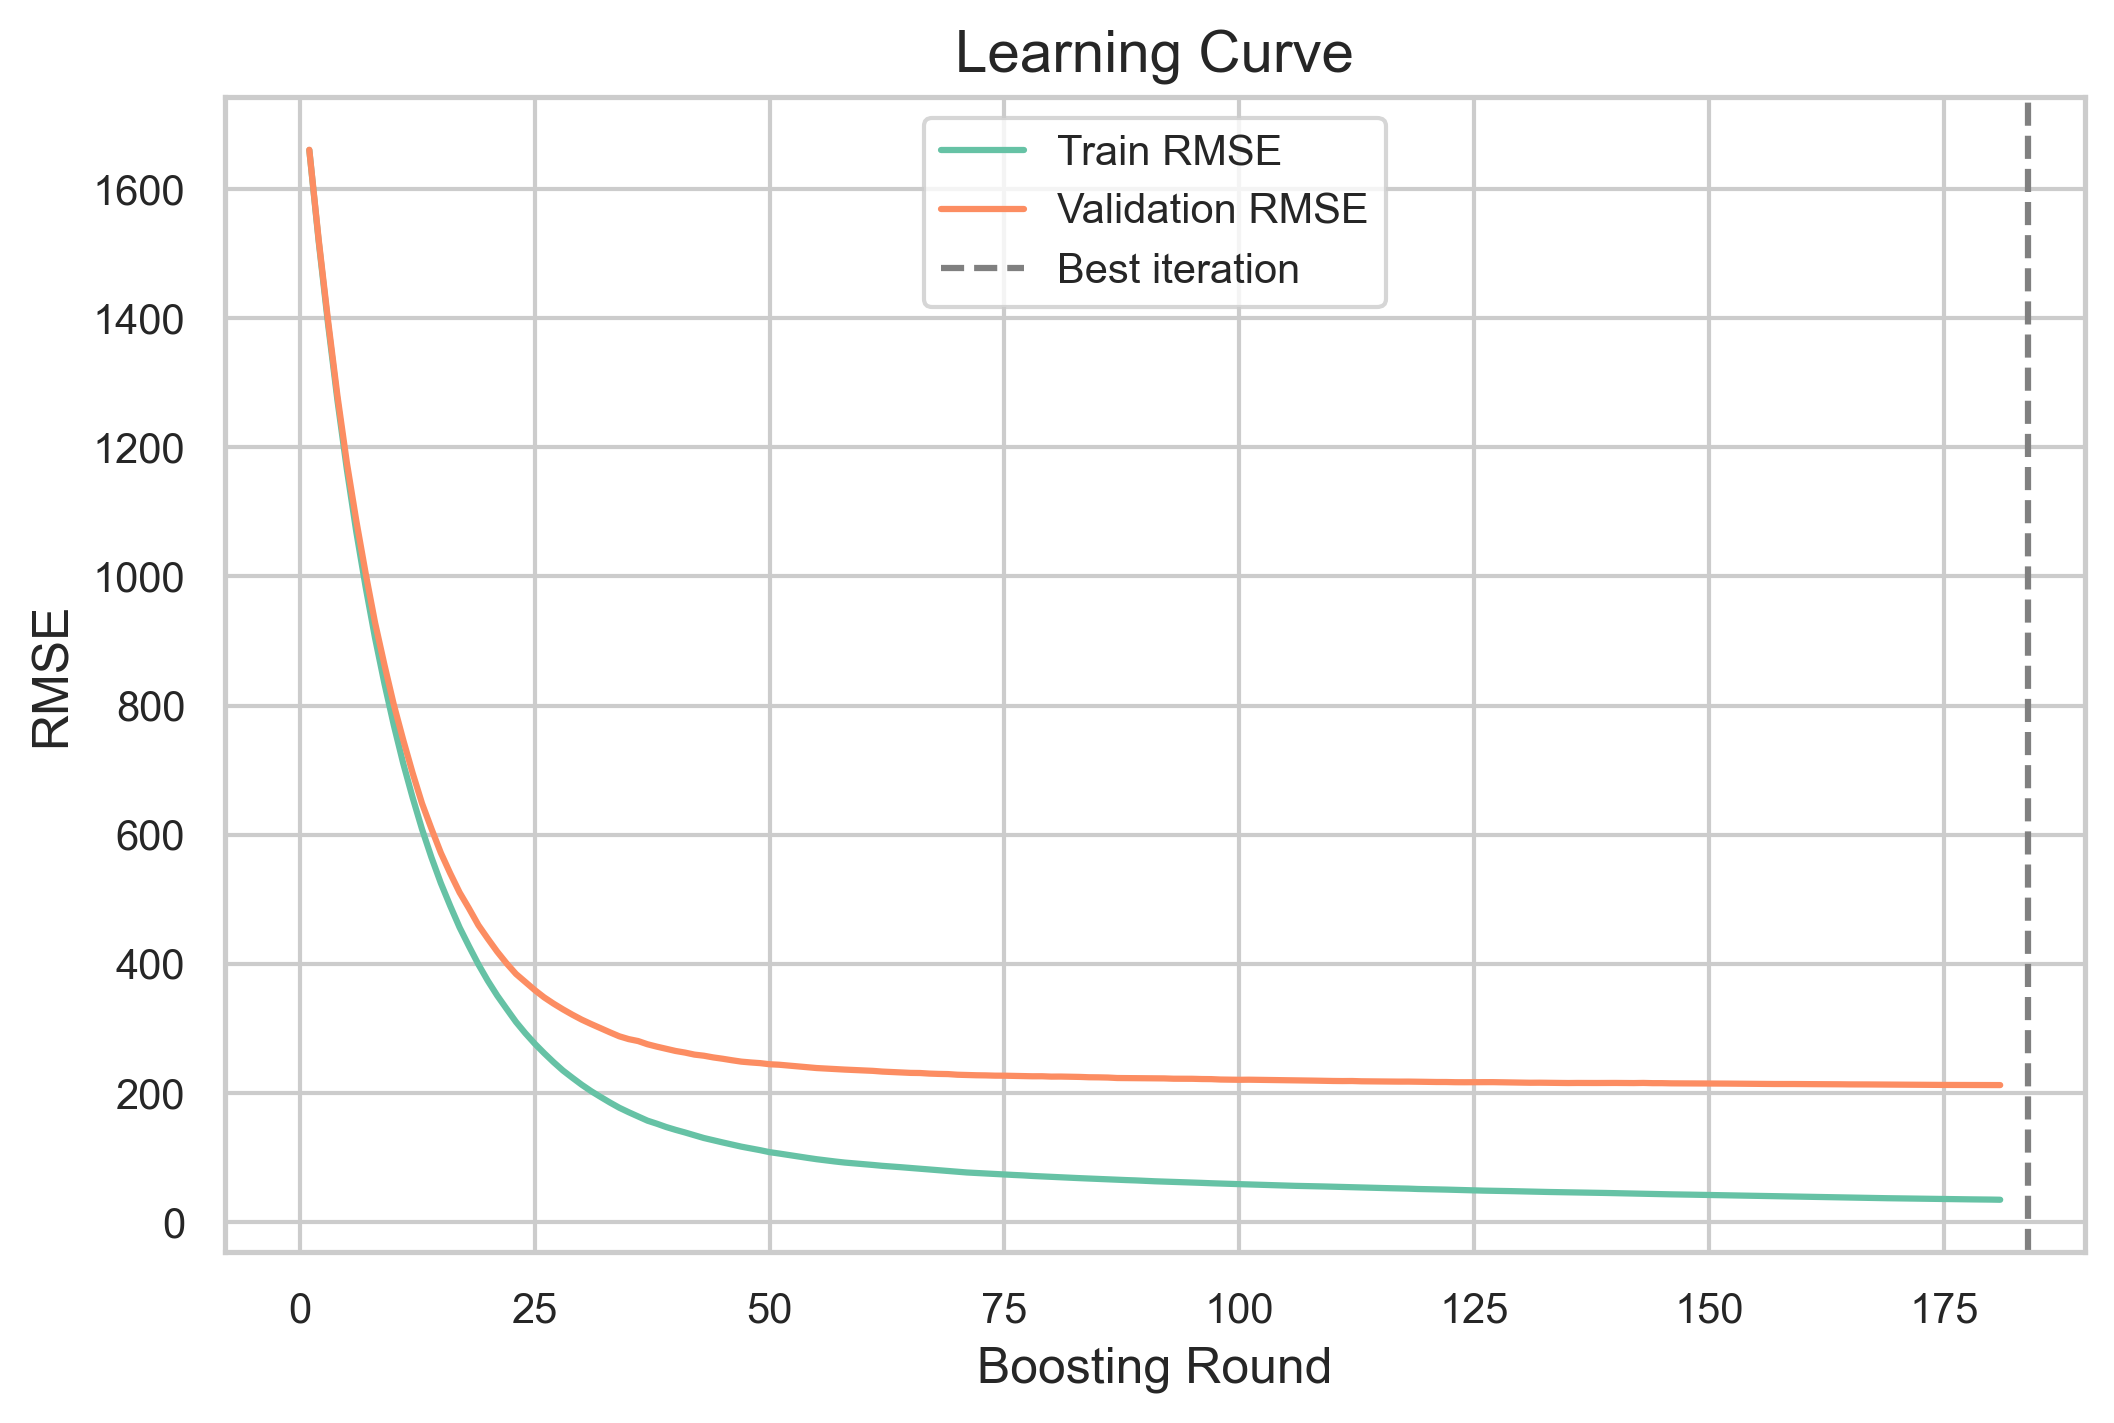

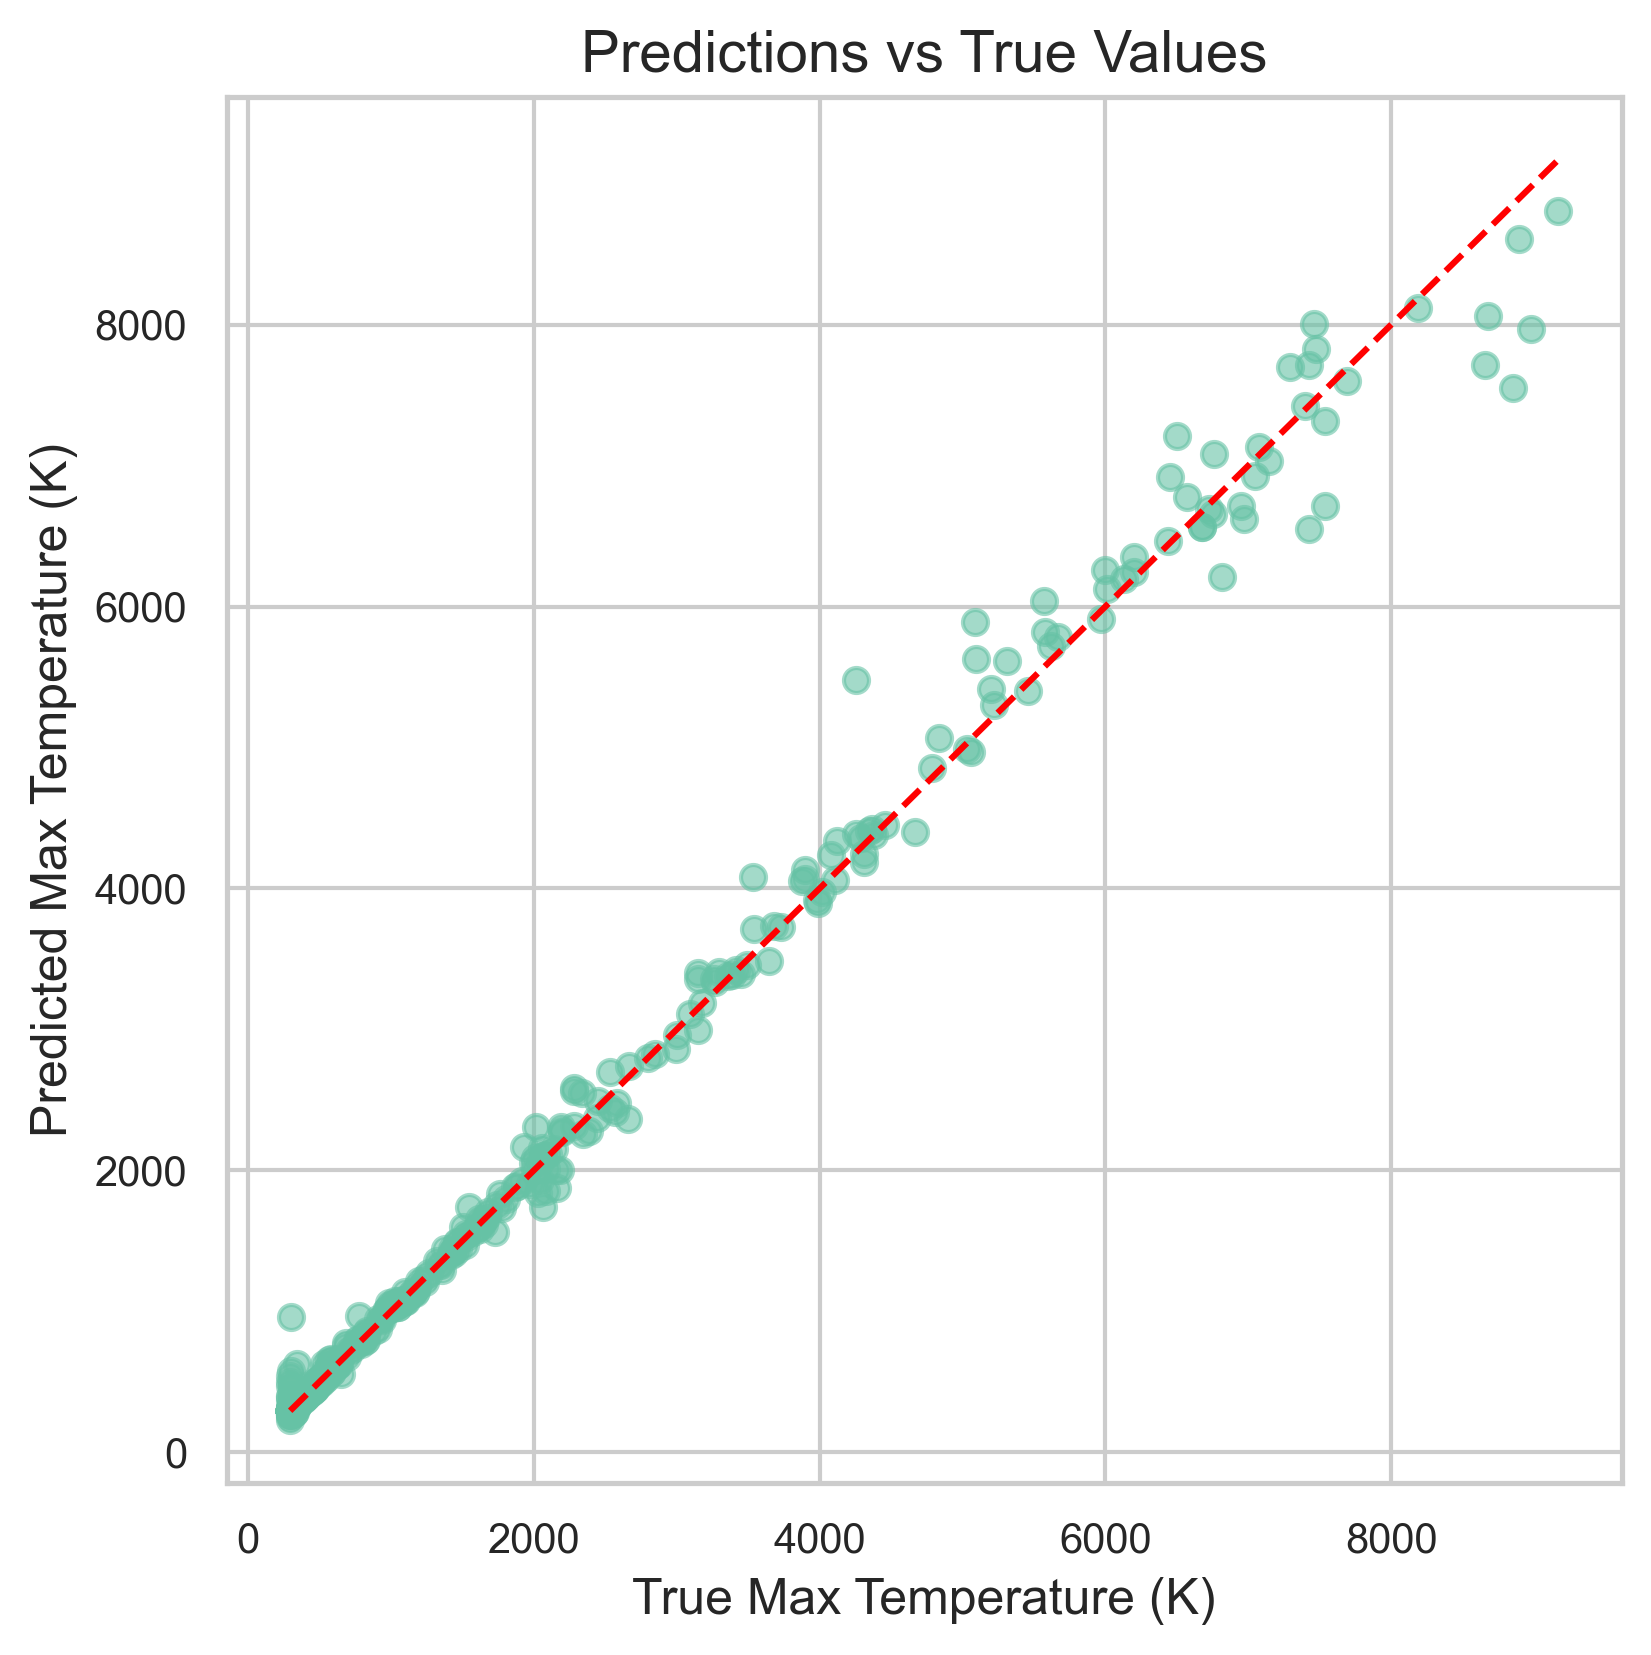

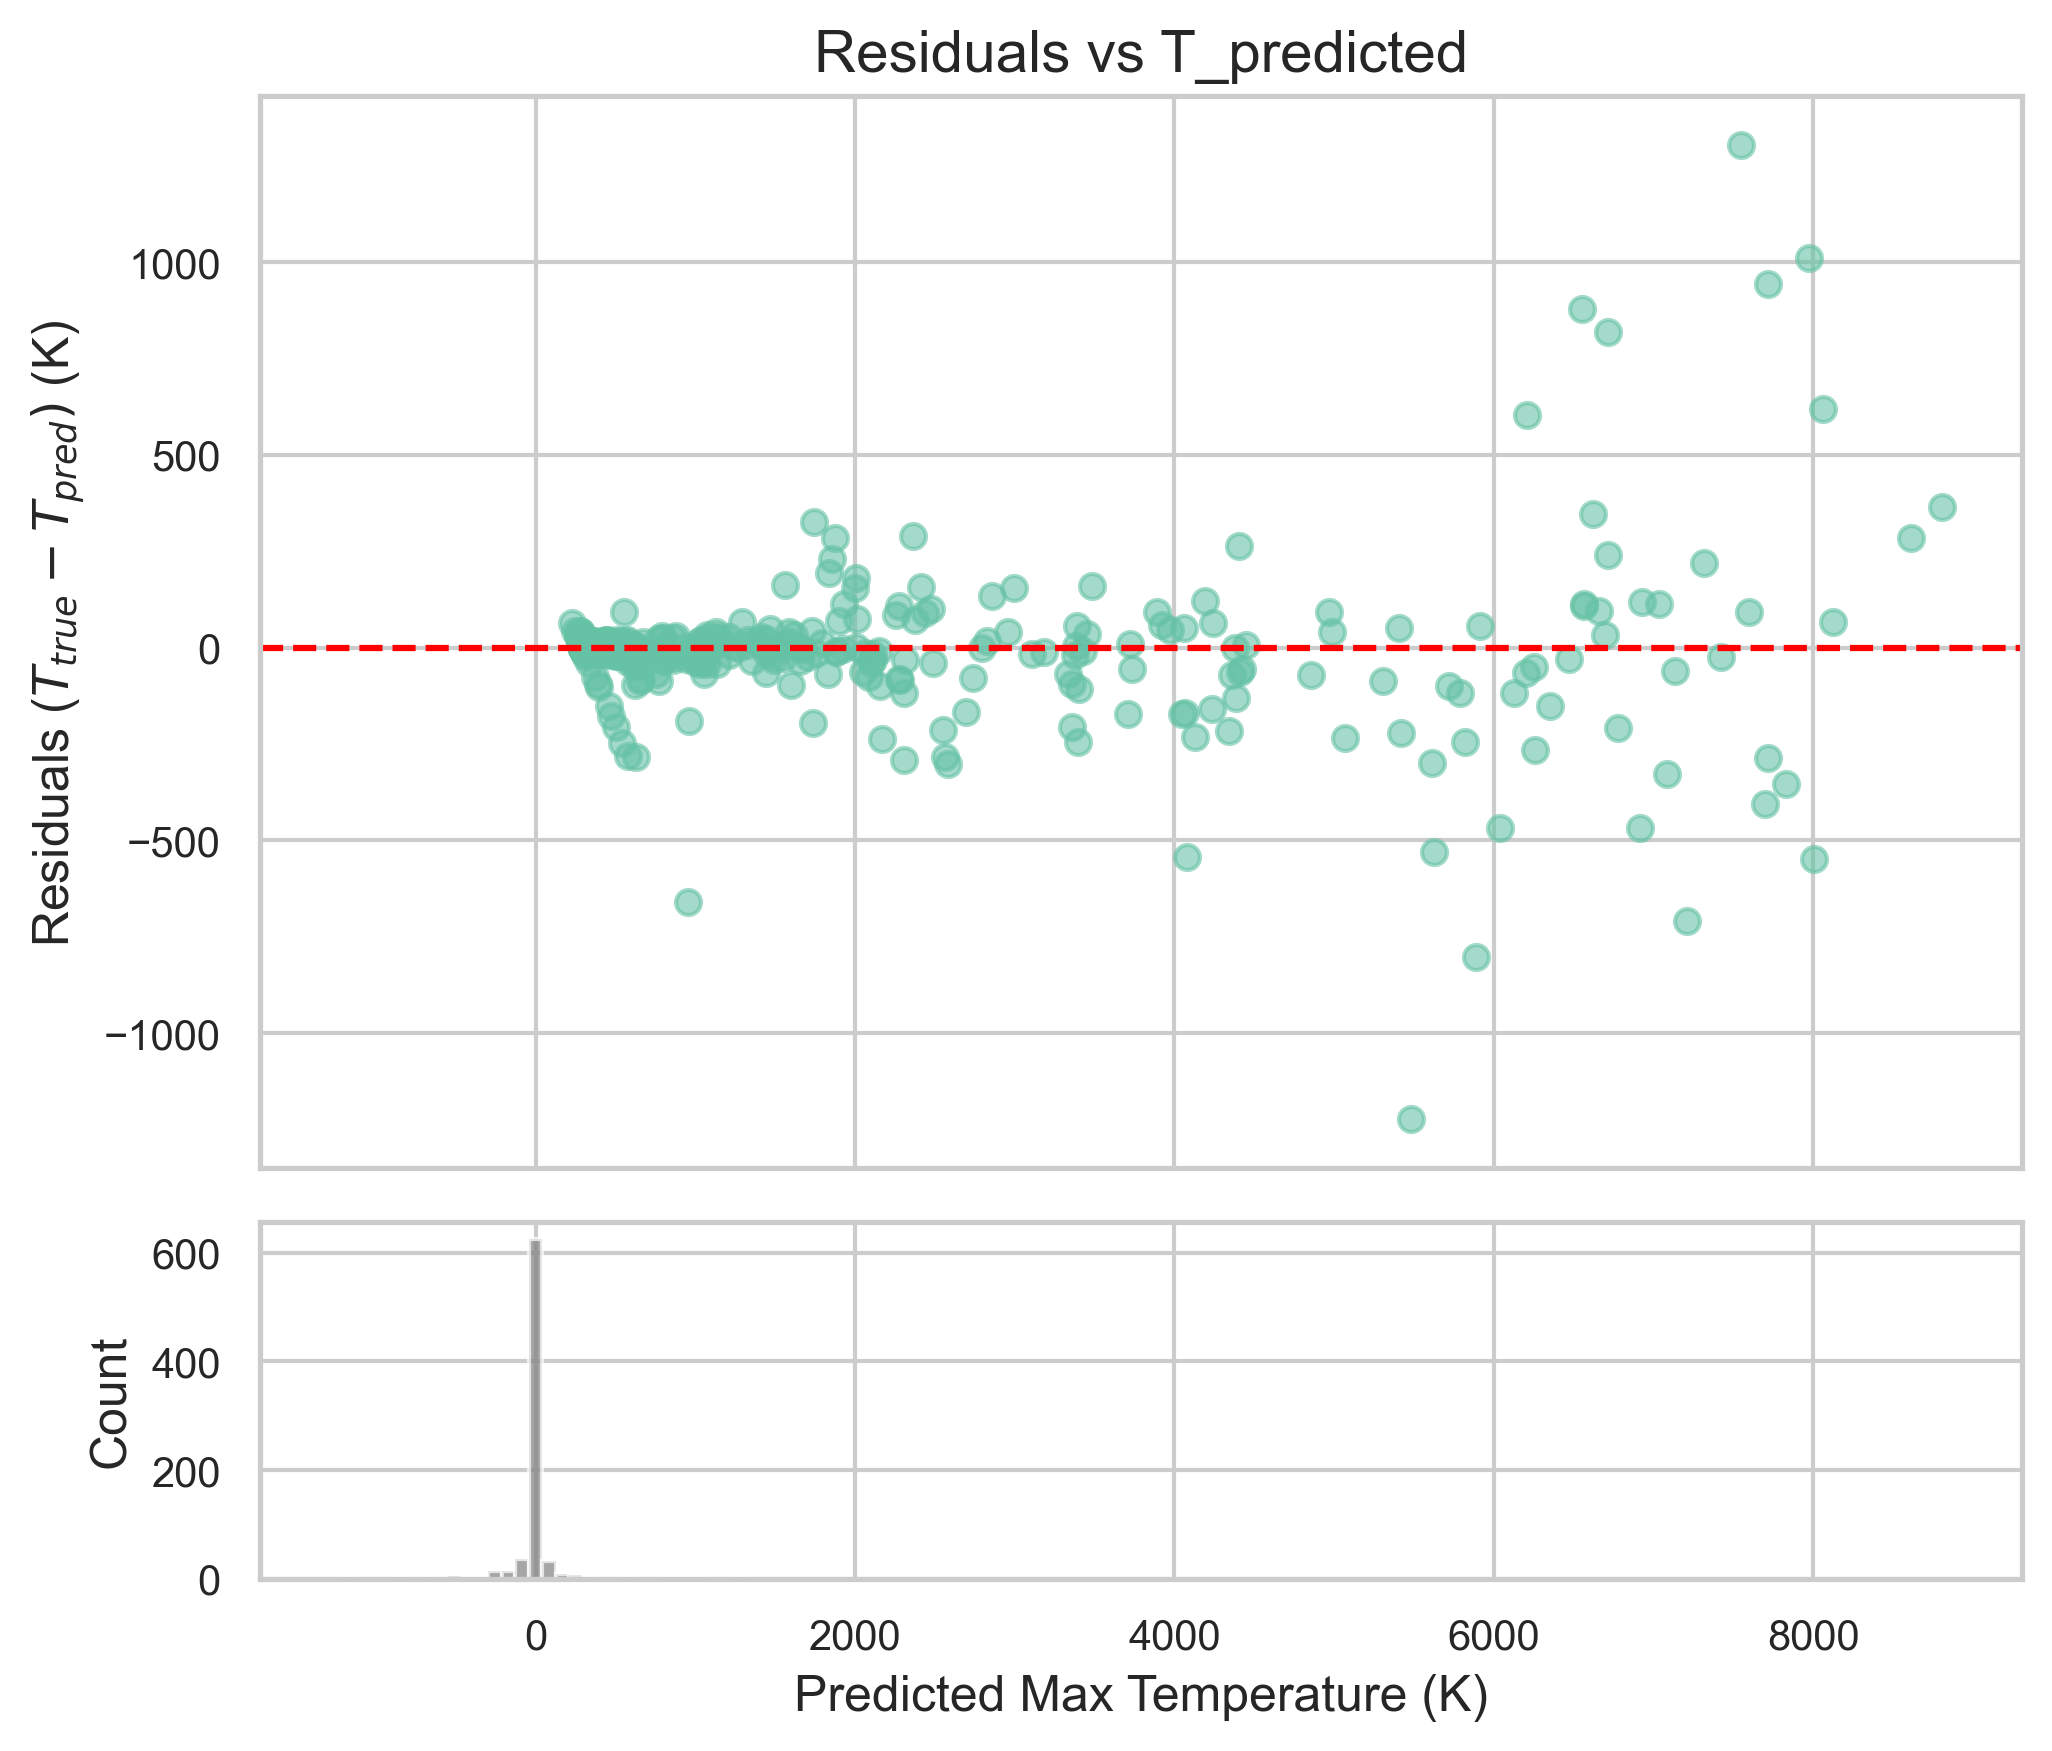

C:\Users\tomha\AppData\Local\Temp\ipykernel_14588\1415731115.py:201: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(sorted_imp.values()), y=list(sorted_imp.keys()), palette='viridis')


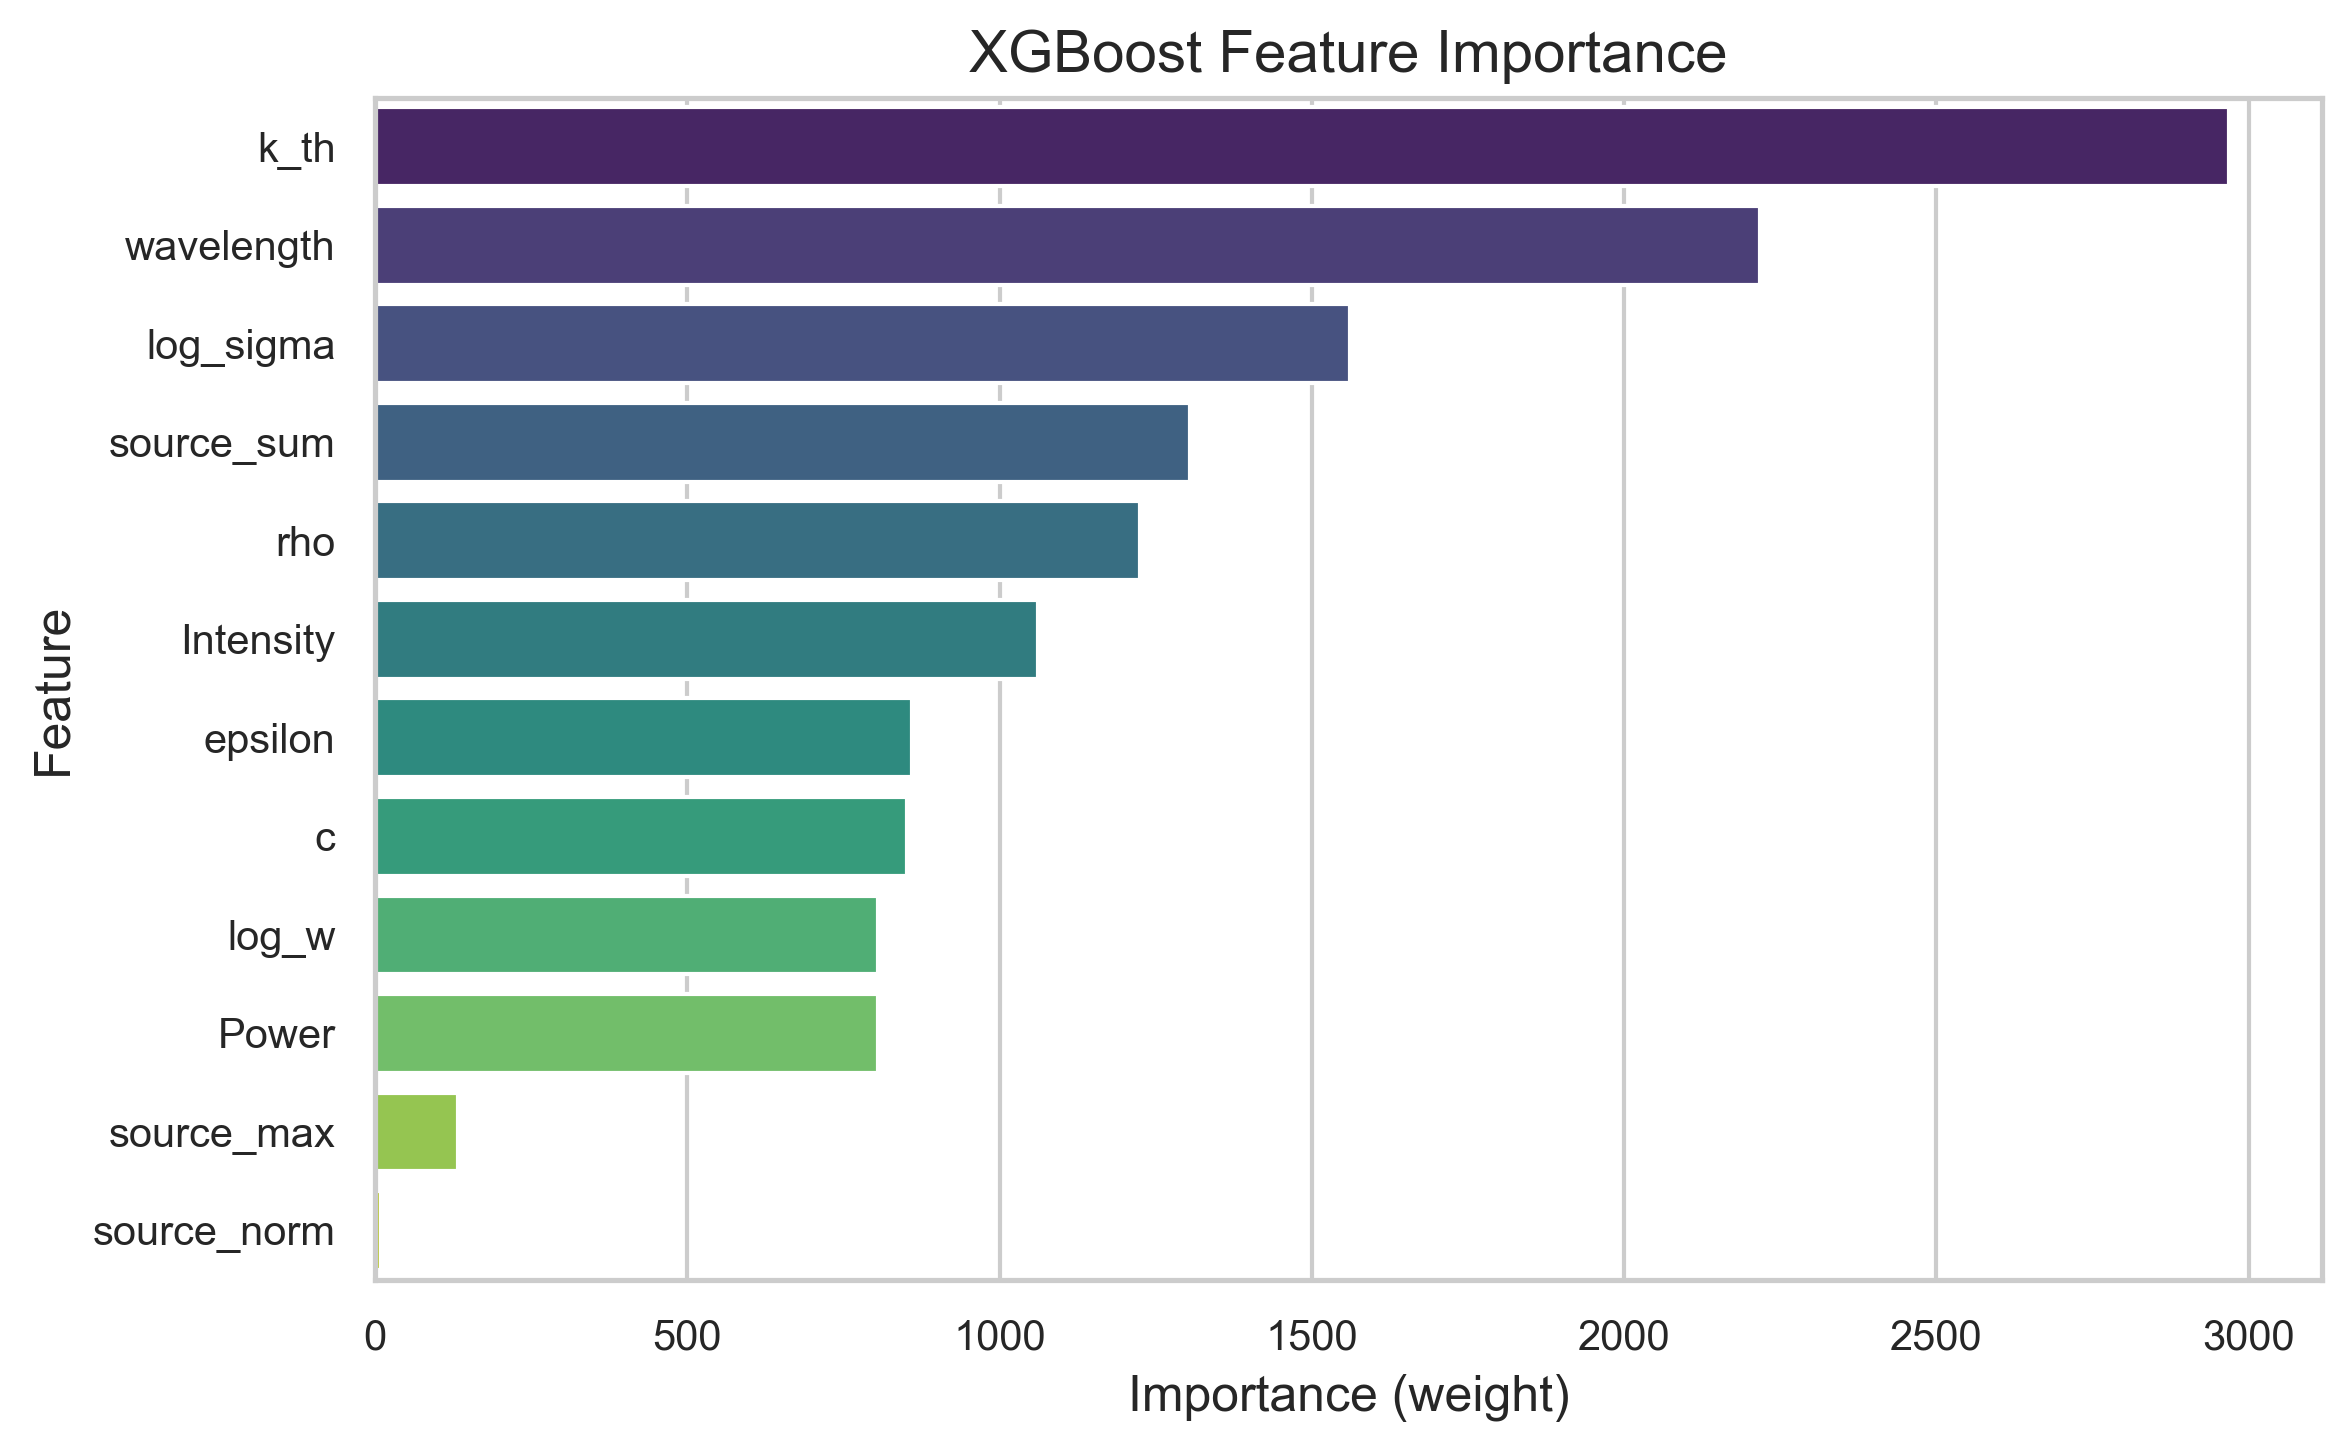

In [21]:
"""
XGBoost Regression for Maximum Temperature Prediction

This script implements a complete workflow for training, evaluating, 
and visualizing an XGBoost model to predict the maximum temperature 
resulting from laser-material interactions.

Key Sections:

1. Load and Preprocess Data:
   - Reads 'all_materials.csv' and selects relevant features.
   - Filters temperature values to a physically reasonable range (293.15–10000 K).
   - Encodes categorical variables (e.g., materials) if needed.
   - Returns input features X and target y.

2. Metric Definitions:
   - Implements Mean Absolute Percentage Error (MAPE) as a custom metric.

3. Randomized Cross-Validation (CV) for Hyperparameter Optimization:
   - Performs randomized search over a given hyperparameter grid.
   - Uses K-Fold CV to train multiple XGBoost models.
   - Tracks train and validation RMSE for each fold and each parameter set.
   - Early stopping is applied to avoid overfitting.
   - Returns CV results, averaged learning curves, and best hyperparameters.

4. Plotting Functions:
   - plot_cv_hyperparam: CV RMSE vs hyperparameter with error bars.
   - plot_learning_curve: Train vs validation RMSE vs boosting rounds.
   - plot_predictions: Predicted vs true maximum temperature.
   - plot_residuals_with_histogram: Residuals vs predictions with histogram.
   - plot_feature_importance: Bar chart of feature importance from XGBoost.

5. Main Execution:
   - Loads and splits data into train/validation/test sets (60/20/20 split).
   - Performs randomized CV to select optimal hyperparameters.
   - Trains final model on combined train+validation set.
   - Evaluates performance on independent test set (RMSE, MAE, MAPE, R²).
   - Generates journal-ready plots:
     - Learning curves
     - Predictions vs true values
     - Residuals and residual histogram
     - Feature importance ranking

Dependencies:
- pandas, numpy, matplotlib, seaborn, xgboost
- scikit-learn (for train_test_split, KFold, metrics)
"""



import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import KFold, ParameterSampler, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder
import os

# -------------------------------
# Load and preprocess CSV
# -------------------------------
def load_and_preprocess_data(filename='all_materials.csv'):
    notebook_dir = os.getcwd()
    file_path = os.path.join(notebook_dir, filename)
    
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"CSV not found at {file_path}")

    column_names = [
         'log_w', 'wavelength', 'log_sigma','Power',
        'k_th', 'rho', 'c', 'epsilon', 'source_sum','source_max','source_norm','Intensity' ,'max_temperature'
    ]

    df = pd.read_csv(file_path, sep=r"\s+", header=None, names=column_names)
    df = df[(df['max_temperature'] > 293.15) & (df['max_temperature'] < 10000)]

    le = LabelEncoder()
    #df['material_encoded'] = le.fit_transform(df['material'].str.strip())

    X = df[['log_w', 'wavelength', 'log_sigma','Power', 'k_th', 'rho', 'c', 'epsilon','source_sum','source_max',
           'source_norm','Intensity']]
    y = df['max_temperature']
    
    print(f"Loaded {len(df)} rows from {file_path}")
    return X, y

# -------------------------------
# MAPE
# -------------------------------
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# -------------------------------
# Randomized CV for XGBoost
# -------------------------------
def randomized_cv_xgb(X, y, param_grid, n_iter=50, n_splits=5, random_state=42):
    cv_results, train_curves, val_curves = [], [], []
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    param_list = list(ParameterSampler(param_grid, n_iter=n_iter, random_state=random_state))

    for params in param_list:
        fold_rmses, fold_train, fold_val, fold_iters = [], [], [], []

        for train_idx, val_idx in kf.split(X):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            dtrain = xgb.DMatrix(X_train, label=y_train)
            dval   = xgb.DMatrix(X_val, label=y_val)

            evals_result = {}
            model = xgb.train(
                {**params, 'objective':'reg:squarederror', 'seed':random_state, 'verbosity':0},
                dtrain,
                num_boost_round=200,
                evals=[(dtrain,'train'), (dval,'validation')],
                early_stopping_rounds=50,
                verbose_eval=False,
                evals_result=evals_result
            )

            fold_train.append(np.array(evals_result['train']['rmse']))
            fold_val.append(np.array(evals_result['validation']['rmse']))
            fold_iters.append(model.best_iteration)

            y_pred = model.predict(dval, iteration_range=(0, model.best_iteration+1))
            fold_rmses.append(np.sqrt(np.mean((y_val - y_pred)**2)))

        min_len = min(len(f) for f in fold_train)
        train_curves.append(np.mean(np.vstack([f[:min_len] for f in fold_train]), axis=0))
        val_curves.append(np.mean(np.vstack([f[:min_len] for f in fold_val]), axis=0))

        mean_rmse = np.mean(fold_rmses)
        std_rmse  = np.std(fold_rmses)
        cv_results.append((params, np.mean(fold_iters), mean_rmse, std_rmse))

    best_idx = np.argmin([r[2] for r in cv_results])
    best_params = cv_results[best_idx][0]

    return cv_results, train_curves, val_curves, best_idx, best_params

# -------------------------------
# Plotting Functions
# -------------------------------
sns.set(style="whitegrid", palette="Set2")

def plot_cv_hyperparam(cv_results, hyperparam_name, savefile='hyper_parameter_plot'):
    """Plot CV RMSE vs a specific hyperparameter (with error bars)."""
    hyperparam_values = [r[0][hyperparam_name] for r in cv_results]
    mean_rmse = [r[2] for r in cv_results]
    std_rmse  = [r[3] for r in cv_results]

    plt.figure(figsize=(8,5), dpi=300)
    plt.errorbar(
        hyperparam_values,
        mean_rmse,
        yerr=std_rmse,
        fmt='o-', markersize=6, capsize=5, elinewidth=1.5, markeredgewidth=1.5
    )
    plt.xlabel(hyperparam_name, fontsize=12)
    plt.ylabel("Mean CV RMSE", fontsize=12)
    plt.title(f"CV Results: RMSE vs {hyperparam_name}", fontsize=14)
    plt.tick_params(axis='both', which='major', labelsize=10)

    best_idx = np.argmin(mean_rmse)
    best_value = hyperparam_values[best_idx]
    plt.axvline(best_value, color="red", linestyle="--", label=f"Best {hyperparam_name}={best_value}")
    plt.legend(loc='best', fontsize=10)

    if savefile:
        plt.savefig("Hyper_param_final", dpi=300, bbox_inches='tight')
    plt.show()
    return best_value

def plot_learning_curve(train_curve, val_curve, num_boost_round, savefile='learning_curve_plot.png'):
    plt.figure(figsize=(8,5), dpi=300)
    plt.plot(range(1, len(train_curve)+1), train_curve, label='Train RMSE')
    plt.plot(range(1, len(val_curve)+1), val_curve, label='Validation RMSE')
    plt.axvline(num_boost_round, color='gray', linestyle='--', label='Best iteration')
    plt.xlabel('Boosting Round', fontsize=12)
    plt.ylabel('RMSE', fontsize=12)
    plt.title('Learning Curve', fontsize=14)
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.legend(loc='best', fontsize=10)
    if savefile:
        plt.savefig("Learning_curve_final", dpi=300, bbox_inches='tight')
    plt.show()

def plot_residuals(y_true, y_pred, savefile='residuals_plot.png'):
    residuals = y_true - y_pred

  

def plot_residuals_with_histogram(y_pred, residuals, savefile=None):
    """
    Plots residuals vs predicted values with a histogram of residuals underneath.
    
    Parameters:
        y_pred (array-like): Predicted temperatures.
        residuals (array-like): Residuals (y_true - y_pred).
        savefile (str, optional): If provided, saves figure to this path.
    """
    fig, (ax_scatter, ax_hist) = plt.subplots(
        2, 1, figsize=(7, 6), dpi=300, gridspec_kw={'height_ratios': [3, 1]}, sharex=True
    )

    # Scatter plot of residuals
    ax_scatter.scatter(y_pred, residuals, alpha=0.6)
    ax_scatter.axhline(0, color='red', linestyle='--', linewidth=1.5)
    ax_scatter.set_ylabel("Residuals ($T_{true} - T_{pred})$ (K)", fontsize=12)
    ax_scatter.set_title("Residuals vs T_predicted", fontsize=14)
    ax_scatter.tick_params(axis='both', which='major', labelsize=10)
    ax_scatter.grid(True)

    # Histogram of residuals
    ax_hist.hist(residuals, bins=30, color='gray', alpha=0.7)
    ax_hist.set_xlabel("Predicted Max Temperature (K)", fontsize=12)
    ax_hist.set_ylabel("Count", fontsize=12)
    ax_hist.tick_params(axis='both', which='major', labelsize=10)
    ax_hist.grid(True)

    plt.tight_layout()
    if savefile:
        plt.savefig("residuals_combined.png", dpi=300, bbox_inches='tight')
    plt.show()


def plot_feature_importance(model, feature_names, savefile='feature_importance_plot.png', top_n=None):
    """
    Plots XGBoost feature importance.
    
    Parameters:
        model: xgb.Booster or xgb.XGBRegressor
        feature_names: list of feature names
        savefile: filename to save the figure
        top_n: if set, only show the top_n features
    """
    importance_dict = model.get_score(importance_type='weight')
    # Map feature names in case they are like 'f0', 'f1', ...
    importance = {feature_names[int(k[1:])] if k.startswith('f') else k: v for k, v in importance_dict.items()}
    
    # Sort and optionally select top_n
    sorted_imp = dict(sorted(importance.items(), key=lambda item: item[1], reverse=True))
    if top_n is not None:
        sorted_imp = dict(list(sorted_imp.items())[:top_n])
    
    plt.figure(figsize=(8,5), dpi=300)
    sns.barplot(x=list(sorted_imp.values()), y=list(sorted_imp.keys()), palette='viridis')
    plt.xlabel('Importance (weight)', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.title('XGBoost Feature Importance', fontsize=14)
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.tight_layout()
    if savefile:
        plt.savefig("feature_importance_final", dpi=300, bbox_inches='tight')
    plt.show()


def plot_predictions(y_true, y_pred, savefile='Predictions_plot'):
    plt.figure(figsize=(6,6), dpi=300)
    plt.scatter(y_true, y_pred, alpha=0.6)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel("True Max Temperature (K)", fontsize=12)
    plt.ylabel("Predicted Max Temperature (K)", fontsize=12)
    plt.title("Predictions vs True Values", fontsize=14)
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.grid(True)
    if savefile:
        plt.savefig("predictions_final", dpi=300, bbox_inches='tight')
    plt.show()

# -------------------------------
# Main
# -------------------------------
if __name__ == "__main__":
    X, y = load_and_preprocess_data('all_materials.csv')

    # Split 60/20/20
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

    param_grid = {
        'learning_rate': [0.05, 0.1, 0.2, 0.3],
        'max_depth': [4, 6, 8],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.7, 0.8, 1.0],
        'colsample_bytree': [0.7, 0.8, 1.0],
        'gamma': [0, 0.1, 0.5],
        'reg_alpha': [0, 0.1, 0.5],
        'reg_lambda': [1, 2, 5]
    }

    cv_results, train_curves, val_curves, best_idx, best_params = randomized_cv_xgb(
        X_train, y_train, param_grid, n_iter=50, n_splits=5
    )

    print("Best Hyperparameters:", best_params)
    print("CV RMSE:", cv_results[best_idx][2], "±", cv_results[best_idx][3])

   # Train final model on TRAIN+VAL
    X_final_train = pd.concat([X_train, X_val])
    y_final_train = pd.concat([y_train, y_val])
    dtrain_final = xgb.DMatrix(X_final_train, label=y_final_train)

    # Use the same number of boosting rounds as the average best_iteration, capped at 200
    num_boost_round_final = int(np.mean([r[1] for r in cv_results]))
    final_model = xgb.train(
    {**best_params, 'objective':'reg:squarederror', 'seed':42},
    dtrain_final,
    num_boost_round=num_boost_round_final
    )

    # Predict on test set (do not use iteration_range unless you know the model has enough trees)
    dtest = xgb.DMatrix(X_test)
    y_pred_test = final_model.predict(dtest)
    y_pred_test = np.nan_to_num(y_pred_test, nan=0.0, posinf=1e10, neginf=-1e10)

    print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_test)))
    print("Test MAE:", mean_absolute_error(y_test, y_pred_test))
    print("Test MAPE:", mean_absolute_percentage_error(y_test, y_pred_test))
    print("Test R2:", r2_score(y_test, y_pred_test))
    final_model.save_model('xgboost_10x10_data.json')


    # -------------------
    # Journal-ready Plots
    # -------------------
    # Example: plot learning curve for best hyperparameters
    plot_learning_curve(train_curves[best_idx], val_curves[best_idx], int(cv_results[best_idx][1]))

    # Example: plot predictions vs true values
    plot_predictions(y_test, y_pred_test)

    #plot residuals
    # Use this in your main section
    residuals = y_test - y_pred_test
    plot_residuals_with_histogram(y_pred_test, residuals, savefile="residuals_histogram.png")



    feature_cols = ['log_w', 'wavelength', 'log_sigma','Power', 'k_th', 'rho', 'c', 'epsilon',
                'source_sum','source_max','source_norm','Intensity']

    plot_feature_importance(final_model, feature_cols, top_n=12)


# Test model on new unseen types

In [4]:
"""
XGBoost Model Evaluation on New Material Test Sets

This script evaluates a pre-trained XGBoost regression model on
multiple new datasets corresponding to different material types.

Key Steps:

1. Define Files to Test:
   - `data_files` contains CSVs for new materials not included in training:
     transition metals, actinides, alkali metals, alloys, poor metals.

2. Load Trained XGBoost Models:
   - Loads previously saved XGBoost models (`.json`) into memory using `xgb.Booster()`.
   - Supports multiple models (here just one model).

3. Define `evaluate_file` Function:
   - Input: path to CSV file containing test data.
   - Load CSV using same column structure as training.
   - Optionally filters temperature values (commented out here).
   - Separates features (X) and target (y).
   - Converts features to XGBoost `DMatrix` for prediction.

4. Run Predictions:
   - For each model, predict maximum temperatures on the dataset.
   - Replaces NaNs and infinities with numeric values to avoid errors.
   - Prints predictions alongside true values and percentage errors for each row.

5. Compute Evaluation Metrics:
   - RMSE (root mean squared error)
   - MAE (mean absolute error)
   - R^2 (coefficient of determination)
   - Prints these metrics for each model on each dataset.

6. Feature Importance:
   - Prints the weight (frequency of use) of each feature in the XGBoost model.

7. Loop Over All Test Files:
   - Calls `evaluate_file()` for each CSV in `data_files`.
   - Allows batch testing and comparison of model performance across material types.

Outcome:
- Row-by-row prediction table with error percentages.
- Overall metrics (RMSE, MAE, R²) for each dataset.
- Feature importance ranking for transparency.
"""




import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# -----------------------------
# Files to test
# -----------------------------
data_files = [
    "transition_new.csv",
    "actinide_new.csv",
    "alkali_new.csv",
    "alloy_new.csv",
    "poor_metal_new.csv",
]

# -----------------------------
# Load trained models
# -----------------------------
model_files = [
    "xgboost_10x10_data.json"
]

boosters = []
for mf in model_files:
    booster = xgb.Booster()
    booster.load_model(mf)
    boosters.append(booster)

# -----------------------------
# Function: preprocess + test
# -----------------------------
def evaluate_file(file_path):
    print(f"\n=== Testing on {file_path} ===")

    # Load CSV using same columns as training
    column_names = [
        'log_w', 'wavelength', 'log_sigma','Power', 'k_th', 'rho', 'c', 'epsilon',
        'source_sum','source_max','source_norm','Intensity','max_temperature'
    ]

    try:
        df = pd.read_csv(file_path, sep=r"\s+", header=None, names=column_names)
    except Exception as e:
        print(f" Could not read {file_path}: {e}")
        return

    print(f"Rows loaded: {len(df)}")

    # Filter temperatures
    #df = df[(df['max_temperature'] > 293.15) & (df['max_temperature'] < 10000)]
    print(f"Rows after temp filter: {len(df)}")
    if df.empty:
        print(f" No valid rows in {file_path}, skipping.\n")
        return

    # Features + target
    feature_cols = [
        'log_w', 'wavelength', 'log_sigma','Power', 'k_th', 'rho', 'c', 'epsilon',
        'source_sum','source_max','source_norm','Intensity'
    ]
    X = df[feature_cols]
    y = df['max_temperature']

    # DMatrix for XGBoost
    dtest = xgb.DMatrix(X, feature_names=feature_cols)

    # -----------------------------
    # Run all models
    # -----------------------------
    mape_material_list = []
    for i, booster in enumerate(boosters):
        print(f"\nPredictions from model {model_files[i]}:")
        preds = booster.predict(dtest)
        preds = np.nan_to_num(preds, nan=0.0, posinf=1e10, neginf=-1e10)

        # Show predictions
        print("Row\tPredicted\tTrue\tError%")
        for j in range(len(df)):
            predicted = preds[j]
            actual = y.iloc[j]
            abs_percentage_error = abs((predicted - actual) / actual) * 100
            mape_material_list.append(abs_percentage_error)
            print(f"{j}\t{predicted:.3f}\t{actual:.3f}\t{abs_percentage_error:.2f}%")

        # -------------------------
        # Error metrics
        # -------------------------
        rmse = np.sqrt(mean_squared_error(y, preds))
        mae = mean_absolute_error(y, preds)
        r2 = r2_score(y, preds)

        print(f"\nError metrics for {model_files[i]}:")
        print(f"  RMSE: {rmse:.3f}")
        print(f"  MAE : {mae:.3f}")
        print(f"  R²  : {r2:.3f}")
        print(f"  Material MAPE : {np.mean(mape_material_list):.2f}%")


        # -------------------------
        # Feature importance
        # -------------------------
        print("\nFeature importance:")
        importance = booster.get_score(importance_type='weight')
        for f in feature_cols:
            print(f"{f}: {importance.get(f, 0)}")

# -----------------------------
# Run evaluation for all files
# -----------------------------
for file in data_files:
    evaluate_file(file)
#-------------------------------
# Evaluate MAPE for each material
#-------------------------------



=== Testing on transition_new.csv ===
Rows loaded: 3
Rows after temp filter: 3

Predictions from model xgboost_10x10_data.json:
Row	Predicted	True	Error%
0	5180.375	3575.832	44.87%
1	6497.865	4772.262	36.16%
2	4884.376	4690.857	4.13%

Error metrics for xgboost_10x10_data.json:
  RMSE: 1365.005
  MAE : 1174.555
  R²  : -5.254
  Material MAPE : 28.39%

Feature importance:
log_w: 805.0
wavelength: 2217.0
log_sigma: 1561.0
Power: 805.0
k_th: 2969.0
rho: 1225.0
c: 852.0
epsilon: 859.0
source_sum: 1305.0
source_max: 133.0
source_norm: 10.0
Intensity: 1061.0

=== Testing on actinide_new.csv ===
Rows loaded: 3
Rows after temp filter: 3

Predictions from model xgboost_10x10_data.json:
Row	Predicted	True	Error%
0	2574.299	2183.386	17.90%
1	6071.096	15307.661	60.34%
2	6071.096	16303.830	62.76%

Error metrics for xgboost_10x10_data.json:
  RMSE: 7961.905
  MAE : 6620.071
  R²  : -0.531
  Material MAPE : 47.00%

Feature importance:
log_w: 805.0
wavelength: 2217.0
log_sigma: 1561.0
Power: 805.0
k_t

In [ ]:
import xgboost, sklearn, pandas, numpy
print(xgboost.__version__)
print(sklearn.__version__)
print(pandas.__version__)
print(numpy.__version__)

In [6]:
import xgboost, sklearn, pandas, numpy
print(xgboost.__version__)
print(sklearn.__version__)
print(pandas.__version__)
print(numpy.__version__)

3.0.2
1.7.1
2.3.1
1.26.4
